<h1><b>Self Case Study : Machine Learning</b></h1>

# MPST : Movie Plot Synopses with Tags

<p><b>Abstract Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies. Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance. In this paper, we set out to the task of collecting a corpus of movie plot synopses and tags. We describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie plots and the multi-label associations of these tags with some 14K movie plot synopses. We investigate how these tags correlate with movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring tags from plot synopses. We expect the corpus will be useful in other tasks where analysis of narratives is relevant.</b></p>

<h3><b>Kaggle Link for this problem :</b></h3>
<link>https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags</link>

<h3><b>Objective :</b></h3>
<p><b>Predict 'Tags' for the given movie synopses</b></p>

<h3><b>Metrics Used :</b></h3>
<ul>
    <li><b>F1_micro</b></li>
    <li><b>Hamming Loss</b></li>
</ul>

In [20]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.metrics import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import senticnet as sc

<h3><b>That's how the data is</b></h3>

In [21]:
all_data = pd.read_csv("mpst_full_data.csv")
all_data.shape

(14828, 6)

In [3]:
all_data[:5]

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


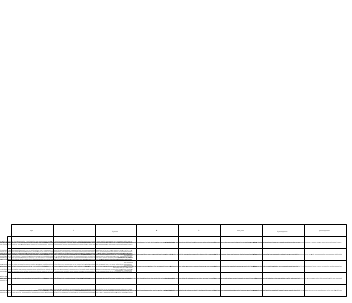

In [202]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas.tools.plotting as plotting # EDIT: see deprecation warnings below

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

plotting.table(ax, all_data[:5])  # where df is your data frame

plt.savefig('./MPST_df.png')

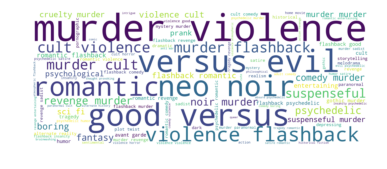

In [197]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

text = " ".join(tag for tag in all_data.tags)

wordcloud = WordCloud(max_font_size=600, max_words=100, background_color="white", width=2000, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("./MPST_blog.png")

<h3><b>Removing duplicates</b></h3>
<p><b>Earlier we have 14828 points and now after removing duplicates, we left with 13757. So 1071 points are removed</b></p>

In [203]:
# CHECK FOR DUPLICATE ROWS
sorted_data=all_data.sort_values('imdb_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
all_data=sorted_data.drop_duplicates(subset={"title"}, keep='first', inplace=False)
all_data.shape

(13757, 8)

<h3><b>Preparing tags vector</b></h3>
<p><b>We have found 71 unique tags in dataset.</b></p>

In [204]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(', '))
tag_vect = vectorizer.fit_transform(all_data['tags'].values)
tags = vectorizer.get_feature_names()
print("Number of unique tags :", tag_vect.shape[1])
print("Some of the tags we have :", tags[:10])

Number of unique tags : 71
Some of the tags we have : ['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 'anti war', 'atmospheric', 'autobiographical', 'avant garde']


In [205]:
freqs = tag_vect.sum(axis=0).A1
data_tag_count = {'tag':tags,'count':freqs}
df_tag_count = pd.DataFrame(data_tag_count)
df_tag_count = df_tag_count.sort_values('count', axis = 0, ascending = False)

<h3><b>Plot: tags frequency per tag</b></h3>

In [210]:
import matplotlib.pyplot as plt

tag_counts = df_tag_count['count'].values

plt.figure(figsize=(6,6))
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
#plt.show()
plt.savefig('./MPST_tags.png')
plt.close()

<h3><b>Top 10 most occuring tags</b></h3>

In [449]:
df_tag_count[:10]

,tag,count
43,murder,5342
68,violence,4105
28,flashback,2751
57,romantic,2734
20,cult,2538
56,revenge,2257
52,psychedelic,1787
17,comedy,1771
65,suspenseful,1000
59,satire,788


<h3><b>OBSERVATION:</b></h3>
<ul>
    <li>murder is the most occuring tag</li>
    <li>Only 9 tags which are ocuuring more than 1000 times which is like 13% of total tags only repeating more than 1000 times</li>
<li>using above plot we can see that the some tags occurs more frequently than others So micro-f1 score is good metric to use</li>
</ul>

<h3><b>Max, Min and average numner of tags in our dataset</b></h3>

In [212]:
tag_quest_count = tag_vect.sum(axis=1).tolist()
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

We have total 13757 datapoints.
Maximum number of tags per question: 25
Minimum number of tags per question: 1
Avg. number of tags per question: 2.994766


<h3><b>Histogram for tags: which tag appear most in all 25 tags space for each synopsis</b></h3>

In [213]:
import seaborn as sns

sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.savefig('./MPST_tags_25.png')
plt.close()

<h3><b>Histogram for top 30 tags</b></h3>

In [220]:
i=np.arange(30)

plt.figure(figsize=(20,10))
df_tag_count.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(i, df_tag_count['tag'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.savefig('./MPST_tags_25_name.png')
plt.close()

<Figure size 1440x720 with 0 Axes>

<h3><b>Data cleaning helper function</b></h3>

In [23]:
import re
from bs4 import BeautifulSoup

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", "can not", phrase)
    phrase = re.sub(r"couldn't", "could not", phrase)
    phrase = re.sub(r"wouldn't", "would not", phrase)
    phrase = re.sub(r"shouldn't", "should not", phrase)
    phrase = re.sub(r"don't", "do not", phrase)
    phrase = re.sub(r"doesn't", "does not", phrase)
    phrase = re.sub(r"haven't", "have not", phrase)
    phrase = re.sub(r"hasn't", "has not", phrase)
    phrase = re.sub(r"ain't", "not", phrase)
    phrase = re.sub(r"hadn't", "had not", phrase)
    phrase = re.sub(r"didn't", "did not", phrase)
    phrase = re.sub(r"wasn't", "was not", phrase)
    phrase = re.sub(r"aren't", "are not", phrase)
    phrase = re.sub(r"isn't", "is not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stop_words = stopwords.words('english')
sno = SnowballStemmer('english')

<h3><b>Cleaning data with stemming: for tfidf and avg w2v lexical feature</b></h3>

In [24]:
cleaned_final_data=[]
for sentance in all_data['plot_synopsis'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z\.]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop_words)
    sentance = ' '.join([sno.stem(word) for word in sentance.split()])
    cleaned_final_data.append(sentance.strip())

all_data['plot_synopsis_cleaned'] = cleaned_final_data

<h3><b>Cleaning data without stemming: for sentiment and emotional features </b></h3>

In [25]:
no_backslash_synopsis = []

for sentance in all_data['plot_synopsis'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = re.sub(r"\'t", "'t", sentance)
    sentance = re.sub(r"\'s", "'s", sentance)
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e for e in sentance.split())
    no_backslash_synopsis.append(sentance.strip())

all_data['no_backslash_synopsis']= no_backslash_synopsis

<h3><b>Preparing count vector for tags: each of length 71</b></h3>

In [26]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(', '), binary='true')
multilabel_y = vectorizer.fit_transform(all_data['tags'].values)

<h3><b>Test Train split</b></h3>

In [27]:
total_size=all_data.shape[0]
train_size=int(0.80*total_size)

x_train=all_data.head(train_size)
x_test=all_data.tail(total_size - train_size)

y_train = multilabel_y[0:train_size,:]
y_test = multilabel_y[train_size:total_size,:]

<h3><b>For getting emotions out of whole synopsis: </b></h3>
<p><b>Sentiments are inherent part of stories and one of the key elements that determine the possible experiences found from a story. For example, depressive stories are expected to be full of sadness, anger, disgust and negativity, whereas a funny movie is possibly full of joy and surprise</b></p>
<p><b>Human emotions are characterized into four affective dimensions (attention, sensitivity, aptitude and pleasantness). Each of these affective dimensions is represented by six different activation levels called sentic levels. These make up to 24 distinct labels called ‘elementary emotions’ that represent the total emotional state of the human mind. SenticNet and SenticPhrase knowledge base consists of 50,000 commonsense concepts with their semantics, polarity value and scores for the basic four affective dimensions. We used this knowledge base to compute average polarity, attention, sensitivity, aptitude, and pleasantness for the synopses.</b></p>
<p><b>We will use SenticPhrase for full synopsis and SenticNet for a word</b></p>

<h3><b>SenticPhrase function :</b></h3>
<p><b>We acn get sentic levels (attention, sensitivity, aptitude and pleasantness) values by .get_sentics() and moodtags (anger, fear, joy, dmiration, disgust, interest, surprise, sadness) values by .get_moodtags() functions. We are also using the polarity values as it tell us that how negative or positive is the story emotionally. We can get polarity by using .get_polarity() function.</b></p>

In [84]:
from sentic import SenticPhrase
def get_sentics_polarity_moodtags(synopsis):
    sp = SenticPhrase(synopsis)
    dict_sentics = sp.get_sentics()
    dict_moodtags = sp.get_moodtags()
    
    all_tags = list(dict_moodtags.keys())
    
    polarity = sp.get_polarity()
    vect = np.zeros(13,dtype = float)
    
    if float(dict_sentics.get('pleasantness')) != 0:
        vect[0] = float(dict_sentics.get('pleasantness'))
    else:
        vect[0]=0.000001
    if float(dict_sentics.get('attention')) != 0:
        vect[1] = float(dict_sentics.get('attention'))
    else:
        vect[1]=0.000001
    if float(dict_sentics.get('sensitivity')) !=0:
        vect[2] = float(dict_sentics.get('sensitivity'))
    else:
        vect[2]=0.000001
    if float(dict_sentics.get('aptitude')) !=0:
        vect[3] = float(dict_sentics.get('aptitude'))
    else:
        vect[3]=0.000001
    if '#anger' in all_tags:
        vect[4] = float(dict_moodtags.get('#anger'))
    else:
        vect[4]=0.000001
    if '#admiration' in all_tags:
        vect[5] = float(dict_moodtags.get('#admiration'))
    else:
        vect[5]=0.000001
    if '#joy' in all_tags:
        vect[6] = float(dict_moodtags.get('#joy'))
    else:
        vect[6]=0.000001
    if '#interest' in all_tags:
        vect[7] = float(dict_moodtags.get('#interest'))
    else:
        vect[7]=0.000001
    if '#disgust' in all_tags:
        vect[8] = float(dict_moodtags.get('#disgust'))
    else:
        vect[8] = 0.000001
    if '#sadness' in all_tags:
        vect[9] = float(dict_moodtags.get('#sadness'))
    else:
        vect[9]=0.000001
    if '#surprise' in all_tags:
        vect[10] = float(dict_moodtags.get('#surprise'))
    else:
        vect[10]=0.000001
    if '#fear' in all_tags:
        vect[11] = float(dict_moodtags.get('#fear'))
    else:
        vect[11]=0.000001

    vect[12] = float(polarity)
    return vect

<h3><b>Observation on SenticNet :</b></h3>
<p><b>In the below output, we can see that senticNet fail to give sentic levels and emotions for the verbs or nouns declared by BlobText. The reason being is that for senticNet, the word should be in the verb first form and singular. So the words like NNP: resides, stallions, returns, advantages; VBZ: Gets, Approves; VBN: proposed etc. are not parse by SenticNet. So we need to convert these words into verb first form and singular. We will use NLTK's WordNet library for that</b></p>
<p><b>We also have some spellings which are incorrect like in below output- educatiion, husbanc, conditiion etc.. So we will try correct these spelling mistakes as much as we can. We will use Pattern library for that.</b></p>

In [455]:
count = 0
blob = TextBlob(x_train['no_backslash_synopsis'].values[9063])
for word, pos in blob.tags:
    if pos == 'VB' or pos == 'NN' or pos == 'VBZ' or pos == 'VBP' or pos == 'VBD' or pos == 'VBN' or pos == 'VBG'\
    or pos=='NNS'or pos =='NNP' or pos=='NNPS':
        if word not in stop_words and len(word)>2:
            try:
                print(word,pos)
                concept_info = sn.concept(word.lower())
                print(concept_info)
                count+=1
                print("\n")
                print("*"*50)
            except:
                print("sentic concept not present")
                pass
print("*"*50)
print("\nTotal words marked by BlobText :",len(blob.tags))
print("\nTotal words parsed by SenticNet :",count)

Baker NNP
{'polarity_value': 'positive', 'polarity_intense': '0.047', 'moodtags': ['#surprise', '#admiration'], 'sentics': {'pleasantness': '0', 'attention': '-0.13', 'sensitivity': '0.058', 'aptitude': '0.059'}, 'semantics': ['cook_meat', 'cook_hamburger', 'cook_food', 'brown_meat', 'eat_outdoors']}


**************************************************
Family NNP
{'polarity_value': 'positive', 'polarity_intense': '0.094', 'moodtags': ['#interest', '#admiration'], 'sentics': {'pleasantness': '0', 'attention': '0.269', 'sensitivity': '-0.17', 'aptitude': '0.182'}, 'semantics': ['kinship', 'sibling', 'elder', 'big_brother', 'best_friend']}


**************************************************
Happy NNP
{'polarity_value': 'positive', 'polarity_intense': '0.894', 'moodtags': ['#joy', '#joy'], 'sentics': {'pleasantness': '0.894', 'attention': '0', 'sensitivity': '0', 'aptitude': '0'}, 'semantics': ['happiness', 'good_feeling', 'happy_feeling', 'joy', 'good_emotion']}


***********************

**************************************************
Perfect NNP
{'polarity_value': 'positive', 'polarity_intense': '0.867', 'moodtags': ['#interest', '#admiration'], 'sentics': {'pleasantness': '0', 'attention': '0.794', 'sensitivity': '0', 'aptitude': '0.941'}, 'semantics': ['best', 'excellent', 'goodness', 'greatness', 'great']}


**************************************************
Promotion NNP
{'polarity_value': 'positive', 'polarity_intense': '0.102', 'moodtags': ['#interest', '#admiration'], 'sentics': {'pleasantness': '0.032', 'attention': '0.312', 'sensitivity': '-0.12', 'aptitude': '0.185'}, 'semantics': ['obligation', 'tedious', 'reinforce', 'incentive', 'task']}


**************************************************
Tour NNP
sentic concept not present
Makes VBZ
sentic concept not present
Decision NNP
{'polarity_value': 'positive', 'polarity_intense': '0.101', 'moodtags': ['#interest', '#admiration'], 'sentics': {'pleasantness': '-0.06', 'attention': '0.32', 'sensitivity': '-0.10

{'polarity_value': 'positive', 'polarity_intense': '0.861', 'moodtags': ['#joy', '#interest'], 'sentics': {'pleasantness': '0.885', 'attention': '0.838', 'sensitivity': '0', 'aptitude': '0'}, 'semantics': ['transport', 'trucking', 'connect_city', 'transportation', 'car_travel']}


**************************************************
Train NNP
{'polarity_value': 'positive', 'polarity_intense': '0.699', 'moodtags': ['#joy', '#surprise'], 'sentics': {'pleasantness': '0.781', 'attention': '-0.72', 'sensitivity': '0', 'aptitude': '0.587'}, 'semantics': ['take', 'direct', 'aim', 'take_aim', 'draw_bead_on']}


**************************************************
Together NNP
{'polarity_value': 'positive', 'polarity_intense': '0.122', 'moodtags': ['#joy', '#admiration'], 'sentics': {'pleasantness': '0.211', 'attention': '0.103', 'sensitivity': '-0.08', 'aptitude': '0.256'}, 'semantics': ['come_together', 'group_of_people', 'bring_together', 'part_of_group', 'team_up']}


**************************

<h3><b>Corrected output for above output:</b></h3>
<p><b>Earlier out of total 338 words marked as noun or verb by TextBlob, only 117 words are recognized and parsed by SenticNet. But now after correction, out of total 338 words, SenticNet recognized 160 words which is a good improvement</b></p>
<p><b>We getting more words parsed by SenticNet in below output as compared to above because all words are in verb base form and singular. Also spelling mistakes like educatiion, husbanc, conditiion are corrected</b></p>

In [456]:
from nltk.stem.wordnet import WordNetLemmatizer
from pattern import en
from pattern.text.en import singularize
# Applying NLTK WordNEt on output of BlobText
blob = TextBlob(x_train['no_backslash_synopsis'].values[9063])
count=0
for word, pos in blob.tags:
    if pos == 'VB' or pos == 'NN' or pos == 'VBZ' or pos == 'VBP' or pos == 'VBD' or pos == 'VBN' or pos == 'VBG'\
    or pos=='NNS'or pos =='NNP' or pos=='NNPS':
        if word not in stop_words and len(word)>2:
            word = WordNetLemmatizer().lemmatize(word.lower(),'v')  # verb base form conversion
            word = singularize(word)
            try:
                print(word,pos)
                concept_info = sn.concept(word)
                print(concept_info)
                print("\n")
                print("*"*50)
                count+=1
            except:
                word = en.spelling.suggest(word.lower())[0][0]  # list of tuples, suggestions with probability: [(suggestion1,p1),(suggestion2,p2)...] where p1>p2
                word = WordNetLemmatizer().lemmatize(word.lower(),'v')
                word = singularize(word)
                try:
                    print(word,pos)
                    concept_info = sn.concept(word)
                    print(concept_info)
                    count+=1
                except:
                    print("sentic concept not present")
                    pass
                pass
print("*"*50)
print("\nTotal words marked by BlobText :",len(blob.tags))
print("\nTotal words parsed by SenticNet :",count)

baker NNP
{'polarity_value': 'positive', 'polarity_intense': '0.047', 'moodtags': ['#surprise', '#admiration'], 'sentics': {'pleasantness': '0', 'attention': '-0.13', 'sensitivity': '0.058', 'aptitude': '0.059'}, 'semantics': ['cook_meat', 'cook_hamburger', 'cook_food', 'brown_meat', 'eat_outdoors']}


**************************************************
family NNP
{'polarity_value': 'positive', 'polarity_intense': '0.094', 'moodtags': ['#interest', '#admiration'], 'sentics': {'pleasantness': '0', 'attention': '0.269', 'sensitivity': '-0.17', 'aptitude': '0.182'}, 'semantics': ['kinship', 'sibling', 'elder', 'big_brother', 'best_friend']}


**************************************************
happy NNP
{'polarity_value': 'positive', 'polarity_intense': '0.894', 'moodtags': ['#joy', '#joy'], 'sentics': {'pleasantness': '0.894', 'attention': '0', 'sensitivity': '0', 'aptitude': '0'}, 'semantics': ['happiness', 'good_feeling', 'happy_feeling', 'joy', 'good_emotion']}


***********************

{'polarity_value': 'positive', 'polarity_intense': '0.042', 'moodtags': ['#interest', '#admiration'], 'sentics': {'pleasantness': '0.038', 'attention': '0.079', 'sensitivity': '0.03', 'aptitude': '0.083'}, 'semantics': ['farm', 'outskirt', 'farm_animal', 'cow', 'fresh_milk']}


**************************************************
home NNP
{'polarity_value': 'positive', 'polarity_intense': '0.069', 'moodtags': ['#surprise', '#surprise'], 'sentics': {'pleasantness': '0', 'attention': '-0.06', 'sensitivity': '0', 'aptitude': '0'}, 'semantics': ['room', 'apartment', 'furniture', 'kitchen', 'flat']}


**************************************************
one NNP
{'polarity_value': 'negative', 'polarity_intense': '-0.76', 'moodtags': ['#anger', '#disgust'], 'sentics': {'pleasantness': '-0.61', 'attention': '0', 'sensitivity': '0.856', 'aptitude': '-0.82'}, 'semantics': ['unfixed', 'indefinite', 'nebulous', 'indecisive', 'coy']}


**************************************************
day NNP
{'polari

{'polarity_value': 'positive', 'polarity_intense': '0.037', 'moodtags': ['#joy', '#interest'], 'sentics': {'pleasantness': '0.085', 'attention': '0.107', 'sensitivity': '-0.08', 'aptitude': '0'}, 'semantics': ['hot_sun', 'sunbright_light', 'hot', 'hot_day', 'bright_light']}


**************************************************
kate NNP
kate NNP
sentic concept not present
discover VBZ
{'polarity_value': 'positive', 'polarity_intense': '0.911', 'moodtags': ['#joy', '#interest'], 'sentics': {'pleasantness': '0.99', 'attention': '0.832', 'sensitivity': '0', 'aptitude': '0'}, 'semantics': ['discovery', 'search', 'review', 'investigation', 'realize']}


**************************************************
disturb NNP
{'polarity_value': 'negative', 'polarity_intense': '-0.06', 'moodtags': ['#sadness', '#disgust'], 'sentics': {'pleasantness': '-0.11', 'attention': '-0.08', 'sensitivity': '0.058', 'aptitude': '-0.17'}, 'semantics': ['loud_cry', 'hear_voice', 'scream', 'freak_out', 'groan']}


****

**************************************************
find VB
{'polarity_value': 'negative', 'polarity_intense': '-0.81', 'moodtags': ['#anger', '#disgust'], 'sentics': {'pleasantness': '-0.77', 'attention': '0', 'sensitivity': '0.816', 'aptitude': '-0.85'}, 'semantics': ['catch_out', 'detect', 'observe', 'discover', 'notice']}


**************************************************
job NNP
{'polarity_value': 'positive', 'polarity_intense': '0.849', 'moodtags': ['#joy', '#admiration'], 'sentics': {'pleasantness': '0.907', 'attention': '0', 'sensitivity': '0', 'aptitude': '0.79'}, 'semantics': ['work', 'task', 'hard_work', 'accomplish', 'find_accomplish']}


**************************************************
which NNP
which NNP
sentic concept not present
would NNP
would NNP
sentic concept not present
provide NNP
{'polarity_value': 'positive', 'polarity_intense': '0.136', 'moodtags': ['#interest', '#admiration'], 'sentics': {'pleasantness': '0', 'attention': '0.348', 'sensitivity': '-0.32', 'a

<h3><b>Important observation : </b></h3>
<p><b>As a story goes from beginning to end, there can be many levels of human emotions which goes side by side along with the story. So instead of getting one value of each emotion in the end, lets split our story in chunks and observe the FLOW OF EMOTIONS.</b></p>
<p><b>Below i have taken the synopsis of movie and divided its synopsis in 5 chunks. For each chunk we have calculated only three emotions - anger, fear and joy. So lets plot those values and see the flow of the emotions</b></p>

<h3><b>Dividing movie synopsis into 5 chunks</b></h3>

In [221]:
# flow of emotion in single synopsis
synopsis = no_backslash_synopsis[122] 
split_synopsis = synopsis.split(' ')
chunk_size = int(len(split_synopsis)/5)
chunk1 = ' '.join(e for e in split_synopsis[0:chunk_size])
chunk2 = ' '.join(e for e in split_synopsis[chunk_size:chunk_size*2])
chunk3 = ' '.join(e for e in split_synopsis[chunk_size*2:chunk_size*3])
chunk4 = ' '.join(e for e in split_synopsis[chunk_size*3:chunk_size*4])
chunk5 = ' '.join(e for e in split_synopsis[chunk_size*4:])

<h3><b>Obtaining emotions- fear, joy and anger for each chunk</b></h3>

In [222]:
anger = []
joy = []
fear = []
for chunk in [chunk1,chunk2,chunk3,chunk4,chunk5]:
    sp = SenticPhrase(chunk)
    dict_tags = sp.get_moodtags()
    anger.append(dict_tags.get('#anger'))
    joy.append(dict_tags.get('#joy'))
    fear.append(dict_tags.get('#fear'))

<h3><b>Plotting emotions for movie twilight</b></h3>

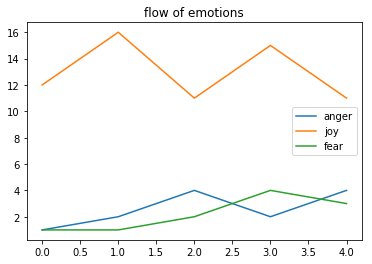

In [223]:
import matplotlib.pyplot as plt 
plt.plot(anger)
plt.plot(joy)
plt.plot(fear)
plt.title("flow of emotions")
plt.legend(['anger', 'joy', 'fear'], loc='best')
plt.savefig("./MPST_flow")

<p><b>As we can see that in first chunk of the story, fear is very less and anger too. Joy is at top. But in second chunk, there is some anger shoots up in emotions. Similarly in end of the story, there is some fear which overtake anger in temr of emotions. But overall joy is most dominating.</b></p>

<p><b>So its more resonable to divide synopsis to chunks and then measure emotions instead of obtaining from whole synopsis in once. So we will divide our chunk into 2 parts and not 5. The reason behind this is that not every chunk is as large as twilight one. There are some synopsis which is just like less than 600 words. So we dont want our chunks too sparse. Hence we decide to divide in two chunks only.</b></p>

<h3><b>Senticphrase for synopsis with chunks</b></h3>

In [83]:
def features_sentic_phrase(synopsis):
    split_synopsis = synopsis.split(' ')
    chunk_size = int(len(split_synopsis)/2)
    chunk1 = ' '.join(e for e in split_synopsis[0:chunk_size])
    chunk2 = ' '.join(e for e in split_synopsis[chunk_size:])
    vect1 = get_sentics_polarity_moodtags(chunk1)
    vect2 = get_sentics_polarity_moodtags(chunk2)
    vect = np.concatenate((vect1,vect2), axis=0)
    return vect

<h3><b>SenticNet feature for verbs:</b></h3>
<p><b>Verbs and nouns tells us more about what is going inside the story. Like if we have verbs like kill, run, scream etc. the we can get an idea easily that something bad going on in story which generates a sense of negative emotions.</b></p>
<p><b>We will use TextBlob library for obtaining verbs(VB) and nouns(NN) out of our synopsis and will get all sentic level and emotions values and ploarity values for each verb and noun in the synopsis. We are just taking average of all these in the end for one synopsis.</b></p>

<h3><b>Using TextBlob and SenticNet for verbs emotions and sentic levels</b></h3>

In [102]:
# use blob text to obtain all verbs and obtain avg polarity intense of all nouns using senticnet
# instead of appending zero in absence of feature, we will append small value 0.000001
from textblob import TextBlob
from senticnet import senticnet as sc
from nltk.stem.wordnet import WordNetLemmatizer
from pattern.text.en import singularize
from pattern import en
import math

sn = sc.SenticNet()
def feature_senticnet(synopsis):
    blob = TextBlob(synopsis)
    aptitude = []
    attention = []
    pleasantness = []
    sensitivity = []
    polarity = []
    all_moodtags = []
    all_words= ['_']
    word_count = 0
    for word, pos in blob.tags:
        if pos == 'VB' or pos == 'NN' or pos == 'VBZ' or pos == 'VBP' or pos == 'VBD' or pos == 'VBN' or pos == 'VBG'\
        or pos=='NNS'or pos =='NNP' or pos=='NNPS':
            if word not in stop_words and len(word)>2:
                word = WordNetLemmatizer().lemmatize(word.lower(),'v')  # verb base form conversion
                word = singularize(word)
                if word not in all_words:
                    try:
                        concept_info = sn.concept(word)
                        all_words.append(word)
                        all_moodtags.append(concept_info.get('moodtags'))
                        if float(concept_info.get('polarity_intense')) !=0:
                            polarity.append(float(concept_info.get('polarity_intense')))
                        else:
                            polarity.append(0.000001)
                        if float(concept_info.get('sentics').get('pleasantness')) !=0:
                            pleasantness.append(float(concept_info.get('sentics').get('pleasantness')))
                        else:
                            pleasantness.append(0.000001)
                        if float(concept_info.get('sentics').get('aptitude')) !=0:
                            aptitude.append(float(concept_info.get('sentics').get('aptitude')))
                        else:
                            aptitude.append(0.000001)
                        if float(concept_info.get('sentics').get('attention')) !=0:
                            attention.append(float(concept_info.get('sentics').get('attention')))
                        else:
                            attention.append(0.000001)
                        if float(concept_info.get('sentics').get('sensitivity')) !=0:
                            sensitivity.append(float(concept_info.get('sentics').get('sensitivity')))
                        else:
                            sensitivity.append(0.000001)
                        word_count+=1
                    
                    except:
                        word = en.spelling.suggest(word.lower())[0][0]  # list of tuples, suggestions with probability: [(suggestion1,p1),(suggestion2,p2)...] where p1>p2
                        word = WordNetLemmatizer().lemmatize(word.lower(),'v')
                        word = singularize(word)
                        if word not in all_words:
                            try:
                                concept_info = sn.concept(word)
                                all_words.append(word)
                                all_moodtags.append(concept_info.get('moodtags'))
                                if float(concept_info.get('polarity_intense')) !=0:
                                    polarity.append(float(concept_info.get('polarity_intense')))
                                else:
                                    polarity.append(0.000001)
                                if float(concept_info.get('sentics').get('pleasantness')) !=0:
                                    pleasantness.append(float(concept_info.get('sentics').get('pleasantness')))
                                else:
                                    pleasantness.append(0.000001)
                                if float(concept_info.get('sentics').get('aptitude')) !=0:
                                    aptitude.append(float(concept_info.get('sentics').get('aptitude')))
                                else:
                                    aptitude.append(0.000001)
                                if float(concept_info.get('sentics').get('attention')) !=0:
                                    attention.append(float(concept_info.get('sentics').get('attention')))
                                else:
                                    attention.append(0.000001)
                                if float(concept_info.get('sentics').get('sensitivity')) !=0:
                                    sensitivity.append(float(concept_info.get('sentics').get('sensitivity')))
                                else:
                                    sensitivity.append(0.000001)
                                word_count+=1
                            except:
                                pass
                        pass
    vect_avg = np.zeros(13,dtype=float)
    vect_avg[0] = float(sum(aptitude)/word_count)
    vect_avg[1] = float(sum(attention)/word_count)
    vect_avg[2] = float(sum(pleasantness)/word_count)
    vect_avg[3] = float(sum(sensitivity)/word_count)
    if '#anger' in all_moodtags:
        vect_avg[4] = float(all_moodtags.count('#anger')/word_count)
    else:
        vect_avg[4]= 0.000001
    if '#admiration' in all_moodtags:
        vect_avg[5] = float(all_moodtags.count('#admiration')/word_count)
    else:
        vect_avg[5]= 0.000001
    if '#joy' in all_moodtags:
        vect_avg[6] = float(all_moodtags.count('#joy')/word_count)
    else:
        vect_avg[6]= 0.000001
    if '#trust' in all_moodtags:
        vect_avg[7] = float(all_moodtags.count('#trust')/word_count)
    else:
        vect_avg[7]= 0.000001
    if '#disgust' in all_moodtags:
        vect_avg[8] = float(all_moodtags.count('#disgust')/word_count)
    else:
        vect_avg[8]= 0.000001
    if '#sadness' in all_moodtags:
        vect_avg[9] = float(all_moodtags.count('#sadness')/word_count)
    else:
        vect_avg[9]= 0.000001
    if '#surprise' in all_moodtags:
        vect_avg[10] = float(all_moodtags.count('#surprise')/word_count)
    else:
        vect_avg[10]= 0.000001
    if '#fear' in all_moodtags:
        vect_avg[11] = float(all_moodtags.count('#fear')/word_count)
    else:
        vect_avg[11]= 0.000001
    
    vect_avg[12] = float(sum(polarity)/word_count)

    return vect_avg

<h3><b>Final function to get emotional and sentic level features for full and verb level synopsis </b></h3>

In [80]:
def all_emotional_features(synopsis):
    vect = features_sentic_phrase(synopsis)
    vect_avg = feature_senticnet(synopsis)
    final_vect = np.concatenate((vect,vect_avg), axis=0)
    return final_vect

<h3><b>Train emotion and sentic level features</b></h3>

In [103]:
from tqdm import tqdm_notebook as tqdm
train_emotional_feat = []
for synopsis in tqdm(x_train['no_backslash_synopsis'].values):
    train_emotional_feat.append(all_emotional_features(synopsis))

<h3><b>Test emotional and sentic level features</b></h3>

In [104]:
test_emotional_feat = []
for synopsis in tqdm(x_test['no_backslash_synopsis'].values):
    test_emotional_feat.append(all_emotional_features(synopsis))

<h3><b>Another sentic feature: Frame Sentics</b></h3>
<p><b>For every verb and noun, if we can get the related contextual words then it would be more defined. We called this as Frame. USnig NLTK library, we can access the frames they made on their corpus and almost every word is related to some frame. We can think of frames as 'related words'</b></p>

<h3><b>Below is the example of framenet. We can see the related words to word 'music'</b></h3>

In [470]:
from nltk.corpus import framenet as fn
[f.name for f in fn.frames_by_lemma('music')]

['People_by_vocation', 'Performers', 'Performing_arts']

<h3><b>Example of frame net on full synopsis:</b></h3>
<p><b>Not all words declared as verb or noun by text blob is present in the frame net of NLTK. In below example we can see that the word 'toreador' is not present in framenet. So we will just skip like these words when we will train our vectors</b></p>

In [471]:
word_pos = []
blob = TextBlob(x_train['no_backslash_synopsis'].values[121])
for word, pos in blob.tags:
    if pos == 'VB' or pos== 'NN':
        if word not in stop_words:
            names =[f.name for f in fn.frames_by_lemma(word.lower())]
            if len(names) != 0:
                print(word)
                print(names)
                print("*"*50)
            else:
                print(word)
                print("frame not present")
                print("*"*50)

film
['Behind_the_scenes', 'Distributed_position']
**************************************************
lady
['People']
**************************************************
mug
['Containers', 'Measure_volume', 'Robbery', 'Smuggling']
**************************************************
beer
['Food']
**************************************************
head
['Accoutrements', 'Appellations', 'Body_description_part', 'Body_mark', 'Body_parts', 'Deny_or_grant_permission', 'Execution', 'Getting_underway', 'Killing', 'Leadership', 'Locale_by_use', 'Mental_property', 'Natural_features', 'Non-gradable_proximity', 'Relative_time', 'Self_motion', 'Weapon', 'Wearing']
**************************************************
music
['People_by_vocation', 'Performers', 'Performing_arts']
**************************************************
man
['Accoutrements', 'Appellations', 'Architectural_part', 'Attaching', 'Bearing_arms', 'Being_attached', 'Being_in_control', 'Being_obligatory', 'Biological_entity', 'Body_part

<h3><b>How we will obtain our features from these frame words :</b></h3>
<p><b>We will use all train frame words and use countvectoriser to get our feature for train and test.</b></p>

In [108]:
# getting train set frame words
from nltk.corpus import framenet as fn
from tqdm import tqdm_notebook as tqdm
import itertools
all_word_pos_train = []
for synopsis in tqdm(x_train['no_backslash_synopsis'].values):
    blob = TextBlob(synopsis)
    word_pos = []
    for word, pos in blob.tags:
        if pos == 'VB' or pos== 'NN':
            if word not in stop_words:
                names =[f.name for f in fn.frames_by_lemma(word)]
                if len(names) != 0:
                    word_pos.append(names)
    word_pos = list(itertools.chain.from_iterable(word_pos))
    all_word_pos_train.append(word_pos)

In [109]:
# getting test set frame words
import itertools
all_word_pos_test = []
for synopsis in tqdm(x_test['no_backslash_synopsis'].values):
    blob = TextBlob(synopsis)
    word_pos = []
    for word, pos in blob.tags:
        if pos == 'VB' or pos== 'NN':
            if word not in stop_words:
                names =[f.name for f in fn.frames_by_lemma(word)]
                if len(names) != 0:
                    word_pos.append(names)
    
    word_pos = list(itertools.chain.from_iterable(word_pos))
    all_word_pos_test.append(word_pos)

In [110]:
all_word_pos_train_new = []
for frame in all_word_pos_train:
    sent = ' '.join([word for word in frame])
    all_word_pos_train_new.append(sent)

In [111]:
all_word_pos_test_new = []
for frame in all_word_pos_test:
    sent = ' '.join([word for word in frame])
    all_word_pos_test_new.append(sent)

<h3><b>Getting frame features for train and test set using CountVectoriser</b></h3>

In [112]:
from sklearn.feature_extraction.text import CountVectorizer

frame_vect = CountVectorizer().fit(all_word_pos_train_new)
train_frame_feat = frame_vect.transform(all_word_pos_train_new)
test_frame_feat = frame_vect.transform(all_word_pos_test_new)

<h3><b>Concatinating our frame word vectors to sentic features</b></h3>

In [113]:
from scipy.sparse import hstack
train_frame_sentic = hstack((train_frame_feat,train_emotional_feat))
test_frame_sentic = hstack((test_frame_feat,test_emotional_feat))

<h3><b>BASELINE MODEL</b></h3>

<p><b>As we know murder, violence and flashback are three most repeating tags. So we will assign these three tags to every datapoint as predicted value and calculate f1 score and hamming loss. This gonna be our baseline model</b></p>

In [472]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(', '))
tag_vect = vectorizer.fit_transform(all_data['tags'].values)
tags = list(vectorizer.get_feature_names())

<h3><b>Baseline Model : f1_micro and hamming loss</b></h3>

In [478]:
import scipy

vect = np.zeros(71,dtype=int)
vect[tags.index('murder')] = 1
vect[tags.index('violence')] = 1
vect[tags.index('flashback')] = 1

base_pred = []
for i in range(0,x_test.shape[0]):
    base_pred.append(vect)

base_pred = scipy.sparse.csr_matrix(base_pred)

print("Accuracy :",metrics.accuracy_score(y_test, base_pred))
print("Hamming loss ",metrics.hamming_loss(y_test,base_pred))


precision = precision_score(y_test, base_pred, average='micro')
recall = recall_score(y_test, base_pred, average='micro')
f1 = f1_score(y_test, base_pred, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, base_pred))

Accuracy : 0.005087209302325582
Hamming loss  0.055370741893219784
Micro-average quality numbers
Precision: 0.3189, Recall: 0.3363, F1-measure: 0.3274


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        39
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00        43
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        41
          12       0.00      0.00      0.00       131
          13       0.00      0.00      0.00        29
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0.00        25
          17       0.00    

<h1><b>Testing features</b></h1>

<h3><b>Logisitc regression with only frame and sentic emotion features (FSE) : calculating f1_micro and hamming loss</b></h3>

In [415]:
# features importance with metrics F1 micro score, hamming loss : SenticPhrase And SenticNet

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *


classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(train_frame_sentic, y_train)
predictions = classifier.predict(test_frame_sentic)

In [416]:
from sklearn import metrics
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))

Accuracy : 0.032703488372093026
Hamming loss  0.053323575171962005
Micro-average quality numbers
Precision: 0.2956, Recall: 0.2392, F1-measure: 0.2645
              precision    recall  f1-score   support

           0       0.07      0.03      0.05        58
           1       0.17      0.19      0.18       112
           2       0.15      0.18      0.16        34
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        20
           5       0.09      0.10      0.10        39
           6       0.00      0.00      0.00        12
           7       0.05      0.07      0.06        43
           8       0.12      0.20      0.15         5
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00         2
          11       0.11      0.05      0.07        41
          12       0.07      0.02      0.03       131
          13       0.00      0.00      0.00        29
          14       0.00      0.00     

<h3><b>Building TFIDF vectors (TF)</b></h3>

In [115]:
# unigram tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer().fit(x_train['plot_synopsis_cleaned'].values)
tfidf_train = vectoriser.transform(x_train['plot_synopsis_cleaned'].values)
tfidf_test = vectoriser.transform(x_test['plot_synopsis_cleaned'].values)


<h3><b>Concatinating TFIDF with frame and sentic emotional features (FSE+TF)</b></h3>

In [116]:
train_frame_sentic_tfidf = hstack((train_frame_sentic,tfidf_train))
test_frame_sentic_tfidf = hstack((test_frame_sentic,tfidf_test))

<h3><b>Logisitc regression with FSE+TF : calculating f1_micro and hamming loss</b></h3>

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(train_frame_sentic_tfidf, y_train)
predictions = classifier.predict(test_frame_sentic_tfidf)

In [120]:
from sklearn import metrics
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))

Accuracy : 0.035247093023255814
Hamming loss  0.052827137242056996
Micro-average quality numbers
Precision: 0.2997, Recall: 0.2382, F1-measure: 0.2654
              precision    recall  f1-score   support

           0       0.08      0.03      0.05        58
           1       0.16      0.19      0.17       112
           2       0.14      0.15      0.14        34
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        20
           5       0.10      0.10      0.10        39
           6       0.00      0.00      0.00        12
           7       0.08      0.07      0.08        43
           8       0.12      0.20      0.15         5
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00         2
          11       0.11      0.05      0.07        41
          12       0.04      0.03      0.04       131
          13       0.00      0.00      0.00        29
          14       0.00      0.00     

<h3><b>Building AVGW2V model using GLoVE: FastText</b></h3>
<p><b>Fasttext (which is essentially an extension of word2vec model), treats each word as composed of character ngrams. So the vector for a word is made of the sum of this character n grams. For example the word vector “apple” is a sum of the vectors of the n-grams ap, app, appl, apple, apple, ppl, pple, pple, ple, ple, le (assuming hyperparameters for smallest ngram[minn] is 3 and largest ngram[maxn] is 6).</b></p>

In [13]:
# https://www.quora.com/What-is-the-main-difference-between-word2vec-and-fastText
# https://blog.manash.me/how-to-use-pre-trained-word-vectors-from-facebooks-fasttext-a71e6d55f27
from gensim.models import KeyedVectors

# Creating the model
en_model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M-subword.vec')

In [14]:
# Getting the tokens 
all_words = []
for word in en_model.vocab:
    all_words.append(word)

# Printing out number of tokens available
print("Number of Tokens: {}".format(len(all_words)))

Number of Tokens: 999994


In [15]:
# Printing out the dimension of a word vector 
print("Dimension of a word vector: {}".format(len(en_model[all_words[0]])))

# Print out the vector of a word 
print("Vector components of a word: {}".format(en_model[all_words[0]]))

Dimension of a word vector: 300
Vector components of a word: [ 2.0300e-02 -1.2300e-02 -7.6000e-03  1.8700e-02  1.7300e-02 -5.2000e-03
  1.4700e-02  1.3640e-01 -4.3500e-02  3.3000e-03 -2.5500e-02 -3.1100e-02
  3.0700e-02 -8.8000e-03 -1.0800e-02 -3.1000e-03 -1.4000e-03  1.3800e-02
 -2.0600e-02  7.4000e-03  2.1000e-02 -1.3800e-02  8.5900e-02  4.2500e-02
  3.7000e-03  3.9400e-02  2.7700e-02  1.7400e-02 -2.3200e-02  8.3000e-03
 -1.4200e-02 -2.7800e-02  4.1000e-03  8.0700e-02  1.1490e-01  7.8000e-02
 -9.4400e-02  5.2000e-03 -4.8000e-03 -1.6700e-02 -3.6200e-02 -6.0100e-02
  8.2000e-03  2.6400e-02 -5.3000e-03  2.6000e-02 -2.7000e-03 -4.0300e-02
  4.2000e-02  3.0400e-02 -5.4200e-02 -2.0200e-02  3.4900e-02  1.0000e-02
  9.1700e-02  4.8700e-02  6.6900e-02 -1.8200e-02  3.5000e-03 -4.1800e-02
  1.6000e-02 -2.3600e-02 -3.1840e-01  2.3400e-02  7.6600e-02 -2.0000e-04
  1.5800e-02 -1.4500e-02 -3.2800e-02 -2.4100e-02 -5.7900e-02  2.0000e-02
  2.3900e-02 -1.7400e-02 -1.4700e-02 -2.3500e-02  5.2500e-02  2

<h3><b>Train AVGW2V</b></h3>

In [31]:
from tqdm import tqdm

train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(x_train['plot_synopsis_cleaned'].values): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in all_words:
            vec = en_model[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_avgw2v.append(sent_vec)

100%|█████████████████████████████████████████████████████████████████████████| 11005/11005 [38:21:38<00:00,  8.55s/it]


<h3><b>Test AVGW2V</b></h3>

In [34]:
test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(x_test['plot_synopsis_cleaned'].values): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in all_words:
            vec = vec = en_model[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_avgw2v.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 2752/2752 [11:13:47<00:00, 14.50s/it]


<h1><b>Topic Modeling : Latent Dirichilet Allocation (LDA)</b></h1>
<p><b>note: This whole Topic Modeling section readings and code i have taken all of it from the this blog:</b> </p><link>https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24</link>
<p><b>and this Github code</b></p>
<link>https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb
</link>
<p><b> WHAT IT DOES : It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. we are going to apply LDA to a set of documents and split them into topics</b></p>

<h3><b>LDA : Text Preprocessing</b></h3>
<ul>
    <li>Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.</li>
    <li>Words that have fewer than 3 characters are removed.</li>
    <li>All stopwords are removed.</li>
    <li>Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.</li>
    <li>Words are stemmed — words are reduced to their root form.</li>
</ul>

In [35]:
# Topic modeling : Latent Dirichlet Allocation (LDA)
#  It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.
# we are going to apply LDA to a set of documents and split them into topics

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
# LDA preprocessing helper functions
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [41]:
processed_docs_train = x_train['plot_synopsis'].map(preprocess)
processed_docs_test = x_test['plot_synopsis'].map(preprocess)

In [42]:
dictionary_train = gensim.corpora.Dictionary(processed_docs_train)

In [43]:
bow_corpus_train = [dictionary_train.doc2bow(doc) for doc in processed_docs_train]

In [47]:
bow_corpus_test = [dictionary_train.doc2bow(doc) for doc in processed_docs_test]
print(bow_corpus_test[431])
bow_doc_431 = bow_corpus_test[431]
print("*"*50)
for i in range(len(bow_doc_431)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_431[i][0], 
                                                     dictionary_train[bow_doc_431[i][0]], 
                                                     bow_doc_431[i][1]))

[(0, 1), (1, 1), (10, 4), (13, 2), (15, 1), (31, 1), (33, 1), (35, 3), (43, 1), (44, 1), (50, 1), (51, 2), (57, 1), (61, 2), (76, 1), (78, 1), (82, 5), (84, 1), (87, 1), (88, 1), (92, 4), (100, 1), (103, 2), (114, 1), (122, 2), (128, 5), (130, 1), (134, 2), (141, 3), (143, 1), (148, 1), (163, 1), (164, 1), (166, 2), (171, 1), (172, 3), (178, 1), (180, 1), (182, 1), (184, 6), (189, 1), (190, 1), (198, 1), (206, 1), (207, 1), (214, 1), (218, 1), (221, 1), (229, 1), (231, 1), (239, 1), (241, 1), (242, 1), (251, 2), (253, 1), (256, 3), (267, 2), (270, 3), (330, 2), (331, 1), (332, 1), (335, 1), (340, 1), (362, 1), (391, 1), (397, 1), (398, 1), (405, 1), (407, 1), (432, 1), (435, 1), (436, 1), (441, 1), (444, 2), (453, 1), (467, 1), (473, 5), (484, 1), (485, 1), (486, 1), (491, 5), (493, 1), (498, 2), (500, 1), (507, 1), (518, 3), (523, 1), (556, 1), (559, 1), (560, 1), (563, 1), (564, 2), (567, 1), (569, 3), (572, 1), (579, 1), (585, 2), (588, 2), (609, 2), (687, 2), (706, 2), (718, 1), (7

Word 1333 ("board") appears 2 time.
Word 1334 ("book") appears 2 time.
Word 1345 ("cell") appears 1 time.
Word 1346 ("chao") appears 1 time.
Word 1388 ("earlier") appears 1 time.
Word 1420 ("get") appears 1 time.
Word 1455 ("lodg") appears 1 time.
Word 1461 ("manag") appears 2 time.
Word 1489 ("posit") appears 1 time.
Word 1496 ("rais") appears 1 time.
Word 1497 ("rang") appears 1 time.
Word 1503 ("relationship") appears 1 time.
Word 1533 ("shock") appears 1 time.
Word 1553 ("surviv") appears 3 time.
Word 1583 ("version") appears 1 time.
Word 1585 ("visit") appears 1 time.
Word 1607 ("care") appears 1 time.
Word 1625 ("girlfriend") appears 1 time.
Word 1667 ("world") appears 2 time.
Word 1687 ("contact") appears 2 time.
Word 1689 ("control") appears 1 time.
Word 1698 ("fenc") appears 2 time.
Word 1703 ("gate") appears 1 time.
Word 1777 ("ensu") appears 1 time.
Word 1778 ("erupt") appears 2 time.
Word 1809 ("east") appears 1 time.
Word 1820 ("harri") appears 2 time.
Word 1859 ("stick") 

In [54]:
# LDA on BOW : train set
# alpha and eta are hyperparameters in LdaMulticore. But i am using default value which is 1.0 per topic
# num_topics can also be thought of hyperparameter but according to size of our corpus, i just took 100 as random value.
lda_model = gensim.models.LdaMulticore(bow_corpus_train, num_topics=100, id2word=dictionary_train, passes=2, workers=2)

In [55]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.014*"jack" + 0.008*"tell" + 0.005*"kill" + 0.005*"leav" + 0.004*"vampir" + 0.004*"love" + 0.004*"mitch" + 0.003*"take" + 0.003*"return" + 0.003*"know"
Topic: 1 
Words: 0.010*"kill" + 0.006*"kirk" + 0.005*"behmen" + 0.004*"tell" + 0.004*"leav" + 0.004*"jaguar" + 0.004*"infect" + 0.004*"vampir" + 0.003*"spock" + 0.003*"attack"
Topic: 2 
Words: 0.009*"tell" + 0.007*"leav" + 0.006*"go" + 0.006*"michael" + 0.005*"take" + 0.004*"hous" + 0.004*"begin" + 0.004*"famili" + 0.004*"see" + 0.004*"kill"
Topic: 3 
Words: 0.009*"josh" + 0.009*"marcus" + 0.009*"tell" + 0.007*"craig" + 0.007*"leav" + 0.005*"famili" + 0.004*"friend" + 0.004*"go" + 0.004*"help" + 0.004*"take"
Topic: 4 
Words: 0.016*"alex" + 0.010*"alic" + 0.008*"leav" + 0.006*"tell" + 0.005*"kill" + 0.005*"take" + 0.004*"go" + 0.004*"come" + 0.004*"time" + 0.003*"hous"
Topic: 5 
Words: 0.007*"larri" + 0.006*"leav" + 0.006*"time" + 0.005*"tell" + 0.005*"emma" + 0.004*"take" + 0.004*"love" + 0.004*"go" + 0.004*"meet" + 0.

Words: 0.006*"tell" + 0.005*"leav" + 0.005*"go" + 0.004*"take" + 0.004*"kill" + 0.004*"tri" + 0.003*"attack" + 0.003*"grover" + 0.003*"edward" + 0.003*"come"
Topic: 49 
Words: 0.010*"abbi" + 0.009*"kill" + 0.007*"mari" + 0.006*"tell" + 0.006*"go" + 0.006*"donni" + 0.006*"farmer" + 0.005*"take" + 0.005*"leav" + 0.005*"precious"
Topic: 50 
Words: 0.007*"tell" + 0.006*"leav" + 0.006*"jeff" + 0.006*"kill" + 0.005*"sadi" + 0.005*"santa" + 0.004*"go" + 0.004*"take" + 0.003*"know" + 0.003*"come"
Topic: 51 
Words: 0.007*"tell" + 0.005*"leav" + 0.005*"time" + 0.005*"take" + 0.004*"nathan" + 0.004*"go" + 0.004*"meet" + 0.004*"kill" + 0.004*"love" + 0.004*"come"
Topic: 52 
Words: 0.026*"nick" + 0.015*"sean" + 0.007*"kill" + 0.007*"tell" + 0.007*"leav" + 0.005*"bruno" + 0.005*"say" + 0.005*"go" + 0.004*"come" + 0.004*"take"
Topic: 53 
Words: 0.007*"kill" + 0.005*"tell" + 0.004*"take" + 0.004*"leav" + 0.004*"alex" + 0.004*"daffi" + 0.004*"jack" + 0.003*"shoot" + 0.003*"escap" + 0.003*"reveal"
Topic

Words: 0.007*"michell" + 0.007*"kill" + 0.006*"leav" + 0.006*"tell" + 0.006*"go" + 0.006*"marti" + 0.004*"hanna" + 0.004*"get" + 0.004*"return" + 0.003*"time"
Topic: 97 
Words: 0.061*"harri" + 0.020*"chris" + 0.014*"tell" + 0.013*"porter" + 0.012*"sophi" + 0.009*"say" + 0.007*"go" + 0.007*"maud" + 0.007*"ask" + 0.006*"leav"
Topic: 98 
Words: 0.018*"john" + 0.014*"jack" + 0.010*"diana" + 0.008*"danni" + 0.007*"leav" + 0.007*"white" + 0.006*"tell" + 0.006*"snow" + 0.005*"queen" + 0.005*"go"
Topic: 99 
Words: 0.017*"perci" + 0.012*"lisa" + 0.007*"tell" + 0.006*"leav" + 0.006*"hous" + 0.006*"kill" + 0.004*"come" + 0.004*"take" + 0.003*"john" + 0.003*"find"


In [74]:
for index, score in sorted(lda_model[bow_corpus_train[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.7135521769523621	 
Topic: 0.012*"king" + 0.009*"jane" + 0.007*"tell" + 0.005*"leav" + 0.005*"kill" + 0.004*"come" + 0.004*"say" + 0.004*"take" + 0.004*"return" + 0.004*"time"

Score: 0.1096590906381607	 
Topic: 0.007*"larri" + 0.006*"leav" + 0.006*"time" + 0.005*"tell" + 0.005*"emma" + 0.004*"take" + 0.004*"love" + 0.004*"go" + 0.004*"meet" + 0.004*"return"

Score: 0.08388367295265198	 
Topic: 0.016*"henri" + 0.008*"tell" + 0.006*"father" + 0.006*"kill" + 0.006*"leav" + 0.005*"love" + 0.004*"time" + 0.004*"go" + 0.004*"famili" + 0.004*"take"

Score: 0.08119206130504608	 
Topic: 0.009*"tell" + 0.007*"say" + 0.007*"go" + 0.006*"ask" + 0.006*"come" + 0.005*"leav" + 0.005*"take" + 0.005*"see" + 0.005*"room" + 0.004*"look"


In [78]:
# https://www.tutorialspoint.com/How-I-can-convert-a-Python-Tuple-into-Dictionary
topic_modeling_feat_train = []
for synopsis in bow_corpus_train:
    t = lda_model[synopsis]
    temp_dict = dict((y, x) for x, y in t)
    topic_modeling_feat_train.append(temp_dict.get(max(list(temp_dict.keys()))))

topic_modeling_feat_test = []
for synopsis in bow_corpus_test:
    t = lda_model[synopsis]
    temp_dict = dict((y, x) for x, y in t)
    topic_modeling_feat_test.append(temp_dict.get(max(list(temp_dict.keys()))))

<h3><b>Concatinating FSE+TF+AVGW2V</b></h3>

In [121]:
train_final = hstack((train_frame_sentic_tfidf,train_avgw2v))
test_final = hstack((test_frame_sentic_tfidf,test_avgw2v))

<h3><b>Logisitc regression with FSE+TF+AVGW2V : Hyperparam tuning</b></h3>

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model_to_set = OneVsRestClassifier(LogisticRegression())

parameters = {
    "estimator__C": [10**-2,10**-1,10**0,10**1],
    "estimator__penalty" : ['l1','l2']
}

'''def my_hamming(estimator, x_test, y_test):
    y_pred = estimator.predict(x_test)
    hamm = metrics.hamming_loss(y_test,y_pred)
    return hamm'''

#my_scorer = make_scorer(my_hamming, greater_is_better=False)

scoring = {'F1': 'f1_micro', 'Hamming': make_scorer(hamming_loss, greater_is_better=False)}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring=scoring, refit=False)

model_tunning.fit(train_final, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__C': [0.01, 0.1, 1, 10], 'estimator__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring={'F1': 'f1_micro', 'Hamming': make_scorer(hamming_loss, greater_is_better=False)},
       verbose=0)

<h3><b>Optimal Logisitc regression with FSE+TF+AVGW2V : calculating f1_micro and hamming loss</b></h3>

In [123]:
classifier = OneVsRestClassifier(LogisticRegression(C=1.0,penalty='l2'))
classifier.fit(train_final, y_train)
predictions = classifier.predict(test_final)

In [124]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))

Accuracy : 0.03561046511627907
Hamming loss  0.05549357189649525
Micro-average quality numbers
Precision: 0.2801, Recall: 0.2452, F1-measure: 0.2615
              precision    recall  f1-score   support

           0       0.06      0.03      0.04        58
           1       0.16      0.21      0.18       112
           2       0.14      0.15      0.14        34
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        20
           5       0.06      0.10      0.08        39
           6       0.05      0.08      0.06        12
           7       0.05      0.07      0.06        43
           8       0.00      0.00      0.00         5
           9       0.04      0.11      0.06        19
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        41
          12       0.04      0.03      0.03       131
          13       0.00      0.00      0.00        29
          14       0.00      0.00      0

<h3><b>Logisitc regression with FSE+TF+AVGW2V+topic_modeling : calculating f1_micro and hamming loss</b></h3>

In [169]:
train_final_all_feats = hstack((train_final,np.asarray(topic_modeling_feat_train).reshape(-1,1)))
test_final_all_feats = hstack((test_final,np.asarray(topic_modeling_feat_test).reshape(-1,1)))

In [175]:
classifier = OneVsRestClassifier(LogisticRegression(C=1.0,penalty='l2'))
classifier.fit(train_final_all_feats.tocsr(), y_train)
predictions = classifier.predict(test_final_all_feats.tocsr())

In [176]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))

Accuracy : 0.03815406976744186
Hamming loss  0.055452628562070096
Micro-average quality numbers
Precision: 0.2795, Recall: 0.2433, F1-measure: 0.2602
              precision    recall  f1-score   support

           0       0.06      0.03      0.04        58
           1       0.17      0.21      0.18       112
           2       0.14      0.15      0.14        34
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        20
           5       0.06      0.10      0.08        39
           6       0.04      0.08      0.05        12
           7       0.05      0.07      0.06        43
           8       0.00      0.00      0.00         5
           9       0.04      0.11      0.06        19
          10       0.00      0.00      0.00         2
          11       0.03      0.02      0.02        41
          12       0.06      0.04      0.05       131
          13       0.00      0.00      0.00        29
          14       0.00      0.00      

<h3><b>Feature Performance Comparisons : pretty table</b></h3>

In [185]:
# Model Comparsion
print("*****ALL THESE METRICS ARE CALCULATED ON TEST SET*****")
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Features","F1_micro","Hamming loss","Accuracy"]
table.add_row(["Baseline Model",0.3274,0.0553,0.0050])
table.add_row(["FSE",0.2645,0.0533,0.0327])
table.add_row(["FSE+TF",0.2654,0.0528,0.0352])
table.add_row(["FSE+TF+AVGW2V",0.2615,0.055,0.035])
table.add_row(["FSE+TF+AVGW2V+TP",0.2602,0.055,0.0381])
print(table)
print("FSE : frame, sentic and emotion feature")
print("TF : TFIDF featurization unigram")
print("AVGW2V : avg word2vec using FastText")
print("TP : Topic Modeling using LDA")

*****ALL THESE METRICS ARE CALCULATED ON TEST SET*****
+------------------+----------+--------------+----------+
|     Features     | F1_micro | Hamming loss | Accuracy |
+------------------+----------+--------------+----------+
|  Baseline Model  |  0.3274  |    0.0553    |  0.005   |
|       FSE        |  0.2645  |    0.0533    |  0.0327  |
|      FSE+TF      |  0.2654  |    0.0528    |  0.0352  |
|  FSE+TF+AVGW2V   |  0.2615  |    0.055     |  0.035   |
| FSE+TF+AVGW2V+TP |  0.2602  |    0.055     |  0.0381  |
+------------------+----------+--------------+----------+
FSE : frame, sentic and emotion feature
TF : TFIDF featurization unigram
AVGW2V : avg word2vec using FastText
TP : Topic Modeling using LDA


<h3><b>Research paper for this case study available on kaggle : </b></h3> <link>https://www.aclweb.org/anthology/L18-1274#page=7&zoom=100,0,553 </link>

<h3><b>Other references i took help from:</b></h3>
<ul>
<li>http://rwet.decontextualize.com/book/textblob/</li>
<li> https://stackoverflow.com/questions/31387905/converting-plural-to-singular-in-a-text-file-with-python</li>
<li>https://stackoverflow.com/questions/3753021/using-nltk-and-wordnet-how-do-i-convert-simple-tense-verb-into-its-present-pas</li>
<li>https://www.clips.uantwerpen.be/pages/mbsp-tags</li>
<li>https://pypi.org/project/senticnet/</li>
<li>https://pypi.org/project/sentic/</li>
<li>https://www.nodebox.net/code/index.php/Linguistics#verb_conjugation</li>
<li>https://stackoverflow.com/questions/18946017/is-there-a-way-to-install-the-nodebox-english-linguistics-library-through-pip-in</li>
    <li>https://blog.manash.me/how-to-use-pre-trained-word-vectors-from-facebooks-fasttext-a71e6d55f27</li>
</ul>